In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
data_files = [
    'data/chen/multidim_chen_hc_0.txt',
    'data/chen/multidim_chen_hc_1.txt',
    'data/chen/multidim_chen_no_hc.txt',
]

df = pd.DataFrame()

for file in data_files:
    data = pd.read_csv(file, sep=' ', header=None)
    data.loc[:, 'hc'] = file.split('chen_')[1].split('.')[0]
    
    df = df.append(data)
    
    
df = df.melt(id_vars=[0,'hc'])
# drop column variable
# rename columns
df.columns = ['parameter', 'algo_type', 'time_step', 'value']

df

,parameter,algo_type,time_step,value
0,theta0,hc_0,1,0.423072
1,theta1,hc_0,1,0.991904
2,theta2,hc_0,1,0.305659
3,log_posterior,hc_0,1,-8.142060
4,theta0,hc_1,1,0.044807
...,...,...,...,...
119995,log_posterior,hc_1,10000,-7.814722
119996,theta0,no_hc,10000,0.102438
119997,theta1,no_hc,10000,3.176029
119998,theta2,no_hc,10000,0.325295


In [3]:
df_log_posterior = df[df['parameter'] == 'log_posterior']

# groupby algo_tyoe and divide each value by its minimum
df_log_posterior.loc[:, 'relative_value'] = df_log_posterior.groupby(
    ['algo_type'])['value'].transform(lambda x: x.min() / x)

# compute moving average
df_log_posterior.loc[:, 'moving_average_rel_value'] = df_log_posterior.groupby(
    ['algo_type'])['relative_value'].transform(lambda x: x.rolling(1000).mean())

/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


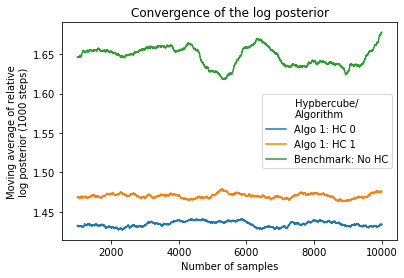

In [4]:

sns.lineplot(data=df_log_posterior, x='time_step', y='moving_average_rel_value', hue='algo_type')
#plt.xlim(0, 5000)


plt.ylabel('Moving average of relative\nlog posterior (1000 steps)')
plt.xlabel('Number of samples')

plt.title('Convergence of the log posterior')

plt.legend(title='Hypbercube/\nAlgorithm', labels=['Algo 1: HC 0', 'Algo 1: HC 1', 'Benchmark: No HC'])

plt.show()

In [5]:
# compute cumulative standard deviation
# for each algo_type

df_log_posterior.loc[:, 'cum_std'] = df_log_posterior.groupby(
    ['algo_type'])['value'].transform(lambda x: x.expanding().std())


/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


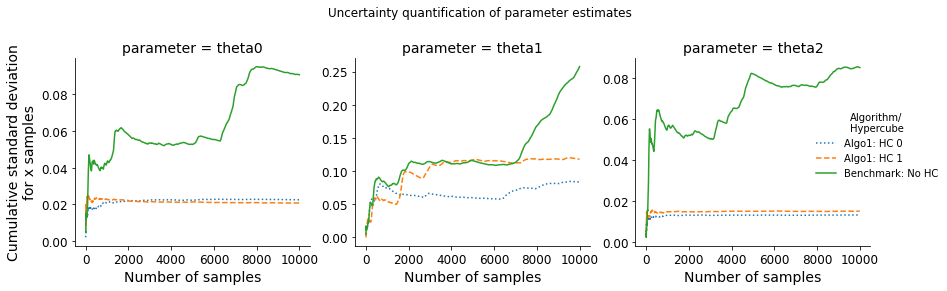

In [19]:
df_parameters = df[df['parameter'] != 'log_posterior']
linestyles = [':', '--', '-']

df_parameters.loc[:, 'cum_std'] = df_parameters.groupby(
    ['algo_type', 'parameter'])['value'].transform(lambda x: x.expanding().std())

# facet grid by parameter
# use different line types for algo_type, use dashed for hypercube and solid for benchmark
g = sns.FacetGrid(df_parameters, col='parameter', hue='algo_type', sharey=False, height=4, aspect=1, legend_out=True, hue_order=['hc_0', 'hc_1', 'no_hc'])
g.map(sns.lineplot, 'time_step', 'cum_std')

for ax in g.axes.flat:
    for line, linestyle in zip(ax.lines, linestyles):
        line.set_linestyle(linestyle)

# add legend to plot and set title
g.add_legend(title='Hypercube/\nAlgorithm')
# set axis labels
g.set_axis_labels('Number of samples', 'Cumulative standard deviation\nfor x samples')

# set title 
g.fig.suptitle('Uncertainty quantification of parameter estimates')

# increase space under title
g.fig.subplots_adjust(top=0.8)

# label the legend and rename the labels to ["Algo1: HC 0", "Algo1: HC 1", "Benchmark: No HC"]
g._legend.set_title('Algorithm/\nHypercube')
for t, l in zip(g._legend.texts, ["Algo1: HC 0", "Algo1: HC 1", "Benchmark: No HC"]): t.set_text(l)

# increase font size
for ax in g.axes.flat:
    ax.tick_params(labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.set_title(ax.get_title(), fontsize=14)
    # set suptitle fontsize
    ax.set_title(ax.get_title(), fontsize=14)
#plt.tight_layout()
# export as svg file
g.savefig('figures/uncertainty_quantification.png', format='png', dpi=1200)

plt.show()

/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


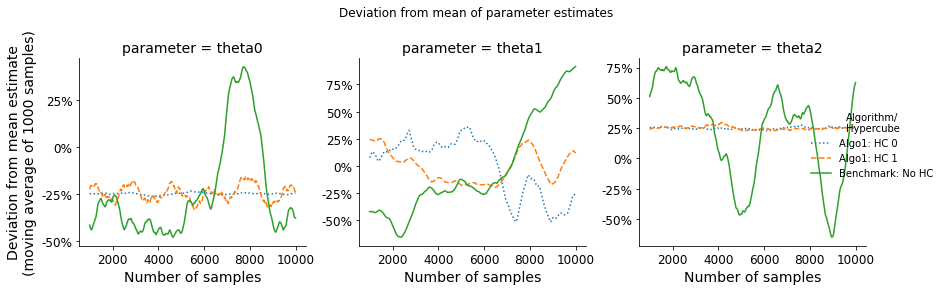

In [20]:

df_parameters.loc[:, 'deviation_from_mean'] = df_parameters.groupby(
    ['algo_type', 'parameter'])['value'].transform(lambda x: x / x.mean()- 1)

# compute moving average of deviation from mean
df_parameters.loc[:, 'moving_average_deviation_from_mean'] = df_parameters.groupby(
    ['algo_type', 'parameter'])['deviation_from_mean'].transform(lambda x: x.rolling(1000).mean())

# facet grid by parameter, with increased size of each plot
g = sns.FacetGrid(df_parameters, col='parameter', hue='algo_type', sharey=False, height=4, aspect=1, legend_out=True, hue_order=['hc_0', 'hc_1', 'no_hc'])
g.map(sns.lineplot, 'time_step', 'moving_average_deviation_from_mean')

for ax in g.axes.flat:
    for line, linestyle in zip(ax.lines, linestyles):
        line.set_linestyle(linestyle)


# add legend to plot and set title
g.add_legend(title='Hypercube/\nAlgorithm')
# set axis labels
g.set_axis_labels('Number of samples', 'Deviation from mean estimate\n(moving average of 1000 samples)')

# format y axis as percentage
g.set(yticklabels=['{:.0f}%'.format(x*100) for x in g.axes.flat[0].get_yticks()])

# set title 
g.fig.suptitle('Deviation from mean of parameter estimates')

# increase space under title
g.fig.subplots_adjust(top=0.8)

# label the legend and rename the labels to ["Algo1: HC 0", "Algo1: HC 1", "Benchmark: No HC"]
g._legend.set_title('Algorithm/\nHypercube')
for t, l in zip(g._legend.texts, ["Algo1: HC 0", "Algo1: HC 1", "Benchmark: No HC"]): t.set_text(l)

for ax in g.axes.flat:
    ax.tick_params(labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.set_title(ax.get_title(), fontsize=14)
    # set suptitle fontsize
    ax.set_title(ax.get_title(), fontsize=14)

#plt.tight_layout()
# place legend outside of plot
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# export as svg file
g.savefig('figures/uncertainty_quantification_deviation_mean.png', format='png', dpi=1200)

plt.show()

/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/christophmayer/opt/anaconda3/envs/dev_ds_1/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


TypeError: __init__() got an unexpected keyword argument 'ax'

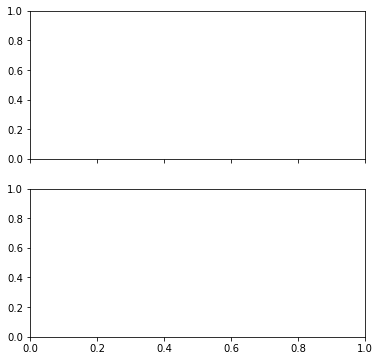

In [8]:
# subplot with two rows and one column
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

df_parameters = df[df['parameter'] != 'log_posterior']

df_parameters.loc[:, 'cum_std'] = df_parameters.groupby(
    ['algo_type', 'parameter'])['value'].transform(lambda x: x.expanding().std())

# facet grid by parameter
g = sns.FacetGrid(df_parameters, col='parameter', hue='algo_type', sharey=False, height=4, aspect=1, ax=axes[0])
g.map(sns.lineplot, 'time_step', 'cum_std')

# add legend to plot and set title
g.add_legend(title='Hypercube/\nAlgorithm')
# set axis labels
g.set_axis_labels('Number of samples', 'Cumulative standard deviation\nfor x samples')

# set title 
g.fig.suptitle('Uncertainty quantification of parameter estimates')

# increase space under title
g.fig.subplots_adjust(top=0.8)

# label the legend and rename the labels to ["Algo1: HC 0", "Algo1: HC 1", "Benchmark: No HC"]
g._legend.set_title('Algorithm/\nHypercube')
for t, l in zip(g._legend.texts, ["Algo1: HC 0", "Algo1: HC 1", "Benchmark: No HC"]): t.set_text(l)


#plt.tight_layout()
# export as svg file
g.savefig('figures/uncertainty_quantification.eps', format='eps', dpi=1200)

plt.show()